In [1]:
import xarray as xr
import rioxarray
from pathlib import Path
time_series_folder = '../output_folder/completeness_analysis/'
nasa_time_series_name = '2021_SuomiNPP_nasa_time_series_fsc.nc'
meteofrance_time_series_name = '2021_meteofrance_time_series.nc'

meteofrance_time_series_path= Path(f"{time_series_folder}").joinpath(meteofrance_time_series_name)
nasa_time_series_path= Path(f"{time_series_folder}").joinpath(nasa_time_series_name)


ds = xr.open_dataset(meteofrance_time_series_path).isel(time=slice(1,30))

In [2]:
def reproject_dataset(dataset: xr.Dataset, new_crs: str) -> xr.Dataset:
    # Rioxarray reproject nearest by default
    return dataset.rio.write_crs(dataset.data_vars['spatial_ref'].attrs['spatial_ref']).rio.reproject(new_crs).rename({'x': 'lon', 'y': 'lat'})

#meteofrance_m = reproject_dataset(ds, new_crs="epsg:32631")

In [25]:
mask = ds==0
mask.data_vars['spatial_ref'].attrs['spatial_ref'] = ds.data_vars['spatial_ref'].attrs['spatial_ref']

In [21]:

reproject_dataset(mask.astype('u1'), new_crs="epsg:32631")

In [27]:
mask_repr = reproject_dataset(mask.astype('u1'), new_crs="epsg:32631")

In [39]:
mask_repr.rio.transform()[4]

-223.7315921993385

In [34]:
(mask_repr.lat[-1] - mask_repr.lat[0]) / len(mask_repr.lat)

<xarray.DataArray 'lat' ()> Size: 8B
array(-223.68978103)
Coordinates:
    spatial_ref  int64 8B 0

In [31]:
mask_repr.lon[0] + len(mask_repr.lon)*223.69194457

<xarray.DataArray 'lon' ()> Size: 8B
array(1089053.73222054)
Coordinates:
    lon          float64 8B -1.732e+05
    spatial_ref  int64 8B 0

In [17]:
meteofrance_m.to_netcdf('test_mf_m.nc')

In [12]:
ds.rio.write_crs(ds.data_vars['spatial_ref'].attrs['spatial_ref']).rio

In [ ]:
{'snow_cover': np.float64(11.88026934572342), 'no_snow': np.float64(2.0002732481635763), 'clouds': np.float64(76.45497153568272), 'forest_without_snow': np.float64(2.2171197419670987), 'forest_with_snow': np.float64(7.3329577218567685), 'water': np.float64(0.11440840660641735), 'n_images': 75}

In [1]:
from pathlib import Path
import xarray as xr
from metrics import MeteoFranceSnowCoverProductCompleteness, NASASnowCoverProductCompleteness
time_series_folder = '../output_folder/completeness_analysis/'
nasa_time_series_name = '2021_SuomiNPP_nasa_time_series_fsc.nc'
meteofrance_time_series_name = '2021_meteofrance_time_series.nc'

meteofrance_time_series_path= Path(f"{time_series_folder}").joinpath(meteofrance_time_series_name)
nasa_time_series_path= Path(f"{time_series_folder}").joinpath(nasa_time_series_name)



ds = xr.open_dataset(meteofrance_time_series_path)#, classes=meteofrance_classes, mask_file='../data/vectorial/massifs_WGS84/massifs_WGS84/massifs_mask_eofr62.tiff')
metrics = MeteoFranceSnowCoverProductCompleteness(ds, mask_file='../data/vectorial/massifs_WGS84/massifs_WGS84/massifs_mask_eofr62.tiff')
#stats = metrics.year_statistics(months=['january', 'february'], exclude_nodata=True, netcdf_export_path='test_stats.nc', csv_export_path='test_stats.csv')

In [2]:
ds = xr.open_dataset(nasa_time_series_path)
metrics = NASASnowCoverProductCompleteness(ds, mask_file='../data/vectorial/massifs_WGS84/massifs_WGS84/massifs_mask_v10_epsg4326.tiff')
stats = metrics.year_statistics(months=['january', 'february'], exclude_nodata=True, netcdf_export_path='test_stats.nc', csv_export_path='test_stats.csv')

INFO:logger:Processing month january
INFO:logger:Processing month february


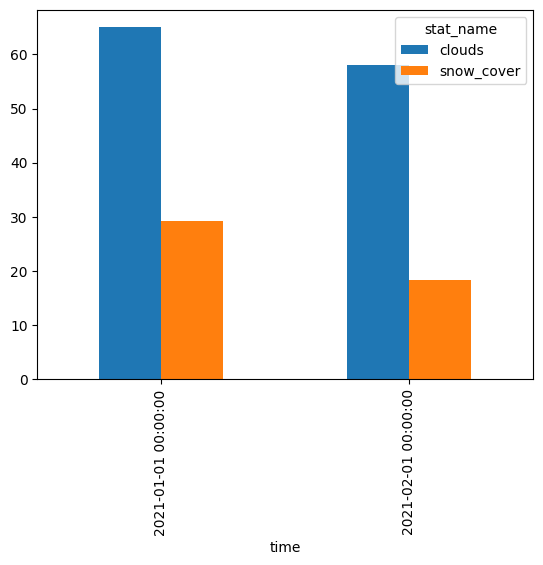

In [3]:
metrics.classes_bar_distribution(stats,classes_to_plot=['clouds', 'snow_cover'])

In [1]:
ls ../data/V10/

VNP10.A2018001.1154.001.2018009185414.nc.aux.xml
VNP10.A2018001.1330.001.2018009183014.nc.aux.xml
VNP10.A2018001.1330.002.2024102164412.nc.aux.xml
VNP10.A2018001.1336.002.2024102164309.nc.aux.xml
VNP10.A2018002.1136.001.2018002232101.nc
VNP10.A2018002.1136.001.2018002232101.nc.aux.xml
VNP10.A2018002.1136.002.2024102190053.nc
VNP10.A2018002.1136.002.2024102190053.nc.aux.xml
VNP10.A2023038.1124.001.2023038173917.nc
VNP10.A2023038.1124.002.2023099093843.nc
VNP10.A2023038.1300.001.2023038191758.nc
VNP10.A2023038.1300.002.2023099093111.nc
VNP10.A2023039.1242.001.2023039193153.nc
VNP10.A2023039.1242.002.2023099113854.nc


In [6]:
cd ..

/home/imperatoren/work/VIIRS_S2_comparison


/home/imperatoren/miniconda3/envs/viirs_env/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [7]:
import xarray as xr
from typing import Dict
import numpy.typing as npt
from pyproj import CRS
import numpy as np

LON, LAT='lon', 'lat'
def georef_data_array(data_array: xr.DataArray, data_array_name: str, crs_wkt: str) -> xr.Dataset:

    """
    Turn a DataArray into a Dataset  for which the GDAL driver (GDAL and QGIS) is able to read the georeferencing
    https://github.com/pydata/xarray/issues/2288
    https://gis.stackexchange.com/questions/230093/set-projection-for-netcdf4-in-python
    """

    data_array.coords[LAT].attrs["axis"]="Y"
    data_array.coords[LON].attrs["axis"]="X"
    data_array.attrs['grid_mapping'] = 'spatial_ref'

    crs_variable = xr.DataArray(0)
    crs_variable.attrs['spatial_ref'] = crs_wkt

    georeferenced_dataset = xr.Dataset({data_array_name: data_array, 'spatial_ref':crs_variable})
    return georeferenced_dataset

def extract_netcdf_latlon_from_viirs_nasa(dataset_object: xr.Dataset)->Dict[str, np.typing.NDArray]:
    latitudes = np.linspace(dataset_object['latitude'].values.min(),dataset_object['latitude'].values.max(), dataset_object.sizes['number_of_lines'])
    longitudes = np.linspace(dataset_object['longitude'].values.min(),dataset_object['longitude'].values.max(), dataset_object.sizes['number_of_pixels'])
    return {LAT: latitudes, LON: longitudes}

geolocation_data = xr.open_dataset('./data/V10/VNP10.A2023038.1124.002.2023099093843.nc', group='GeolocationData')
snow_data = xr.open_dataset('./data/V10/VNP10.A2023038.1124.002.2023099093843.nc', group='SnowData')
ndsi_snow_cover = snow_data.data_vars['NDSI_Snow_Cover']
print(extract_netcdf_latlon_from_viirs_nasa(geolocation_data)['lon'].shape)
ndsi_snow_cover=ndsi_snow_cover.rename({"number_of_lines": LAT, "number_of_pixels": LON}).assign_coords(coords=extract_netcdf_latlon_from_viirs_nasa(geolocation_data))
georef_snow_cover = georef_data_array(ndsi_snow_cover, 'snow_cover', crs_wkt=CRS(4326).to_wkt())

(6400,)


In [50]:
lon_min, lon_max

(<xarray.DataArray 'longitude' ()> Size: 4B
 array(-12.114097, dtype=float32),
 <xarray.DataArray 'longitude' ()> Size: 4B
 array(43.193115, dtype=float32))

In [71]:
from scipy.interpolate import griddata
import numpy as np

latitudes, longitudes = geolocation_data.data_vars['latitude'].isel(number_of_lines=slice(1500,2500), number_of_pixels=slice(5000,6000)), geolocation_data.data_vars['longitude'].isel(number_of_lines=slice(1500,2500), number_of_pixels=slice(5000,6000))
# Define the desired regular latitude-longitude grid
lat_min, lat_max = np.min(latitudes.values), np.max(latitudes.values)
lon_min, lon_max = np.min(longitudes.values), np.max(longitudes.values)
grid_lat, grid_lon = np.mgrid[
    lat_min:lat_max:0.0025,  # Adjust the resolution as needed
    lon_min:lon_max:0.0025,
]

# Interpolate sensor image onto the lat-lon grid
points = np.column_stack((latitudes.values.ravel(), longitudes.values.ravel()))
values = ndsi_snow_cover.isel(lat=slice(1500,2500), lon=slice(5000,6000)).values.ravel()
grid_image = griddata(points, values, (grid_lat, grid_lon), method="cubic")
new_image = xr.DataArray(grid_image, coords={'lat': np.arange(lat_min,lat_max,0.0025), 'lon': np.arange(lon_min,lon_max,0.0025)})
new_snow_cover = georef_data_array(new_image, 'snow_cover', crs_wkt=CRS(4326).to_wkt())
new_snow_cover.to_netcdf('test_v10_snow_cover_crop.nc')

In [73]:
grid_lat.shape

(1837, 2947)

In [68]:

latitudes, longitudes = geolocation_data.data_vars['latitude'].isel(number_of_lines=slice(1500,2500), number_of_pixels=slice(5000,6000)), geolocation_data.data_vars['longitude'].isel(number_of_lines=slice(1500,2500), number_of_pixels=slice(5000,6000))
# Define the desired regular latitude-longitude grid
lat_min, lat_max = np.min(latitudes.values), np.max(latitudes.values)
lon_min, lon_max = np.min(longitudes.values), np.max(longitudes.values)

In [63]:
lon_max

np.float32(10.61577)